In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2024-08-30 12:40:26--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1,1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1,06M  --.-KB/s    in 0,1s    

2024-08-30 12:40:27 (7,75 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print('vocab size: ', vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size:  65


In [5]:
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}
encode = lambda s:[ stoi[c] for c in s]
decode = lambda l:''.join([itos[i] for i in l])

print(encode("hi there"))
print(decode(encode("hi there")))

[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [6]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)


torch.Size([1115394]) torch.int64


In [7]:
n = int(0.9*len(data))

train_data = data[:n]
valid_data = data[n:]

In [8]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} target is {target}")

when input is tensor([18]) target is 47
when input is tensor([18, 47]) target is 56
when input is tensor([18, 47, 56]) target is 57
when input is tensor([18, 47, 56, 57]) target is 58
when input is tensor([18, 47, 56, 57, 58]) target is 1
when input is tensor([18, 47, 56, 57, 58,  1]) target is 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) target is 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) target is 58


In [11]:
torch.manual_seed(1337)
batch_size = 4
block_size = 8
def get_batch(split):
    data = train_data if split == 'train' else valid_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x,y

xb, yb = get_batch("train")
print("inputs")
print(xb.shape)
print(xb)
print("targets")
print(yb.shape)
print(yb)

print("------")
for b in range(batch_size):
    for t in range(block_size):
        context = xb[b,:t+1]
        target = yb[b, t]
        print(f"when input is {context} target is {target}")


inputs
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
------
when input is tensor([24]) target is 43
when input is tensor([24, 43]) target is 58
when input is tensor([24, 43, 58]) target is 5
when input is tensor([24, 43, 58,  5]) target is 57
when input is tensor([24, 43, 58,  5, 57]) target is 1
when input is tensor([24, 43, 58,  5, 57,  1]) target is 46
when input is tensor([24, 43, 58,  5, 57,  1, 46]) target is 43
when input is tensor([24, 43, 58,  5, 57,  1, 46, 43]) target is 39
when input is tensor([44]) target is 53
when input is tensor([44, 53]) target is 56
when input is tensor([44, 53, 56]) target is 1
when input is tensor([44, 53, 56,  1]) ta

In [23]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    # idx is a 4,8 matrix. token_embedding_table(idx) is a 4,8,vocab_size matrix
    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)

        if targets is None:
            loss = None
        else:
            B,T,C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb,yb)
print(logits.shape)
# expected untrain loss = -ln(1/65) for 65 possible elements in the vocabulary
print(loss)


print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.7051, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [24]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [26]:
batch_size = 32
for step in range(10000):
    xb, yb = get_batch("train")
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

2.415212392807007


In [27]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=400)[0].tolist()))



Shomo o st pugino d

ARif w k ithore th, Roue s ped tha okifok, de
Ar.

HESerer ama hatar: Byour vet hr with is aras Tht; thap
YORENGind hathinthethasiouro oulof I and s l SS:
Iffof; hat t-asoresere ashath fover;

AUMENGHave ie? nds to wisus, athal
Fiotha her owa
Fouidif toury aris ior yoress ane hit in,
O:
LETAUns.
Isat t tst far thas s sthasers t Bokerdace
My e
TENIris,
G oue, hon buime.
adive m


In [79]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {c: i for i,c in stoi.items()}
print(itos)
vocab_size = len(stoi)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [80]:
import random
random.seed(42)
random.shuffle(words)

block_size = 8
def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch, in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [93]:
from typing import Any


class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out, generator=g) / fan_in**.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x) -> Any:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.training = True

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, -1, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

In [94]:
torch.manual_seed(42)

In [95]:
n_embed = 24
n_hidden = 128
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *=0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


76579


In [96]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2957
  10000/ 200000: 2.3055
  20000/ 200000: 1.9516
  30000/ 200000: 1.7943
  40000/ 200000: 1.9366
  50000/ 200000: 1.9241
  60000/ 200000: 2.0664
  70000/ 200000: 1.9032
  80000/ 200000: 1.7657
  90000/ 200000: 2.4022
 100000/ 200000: 2.0820
 110000/ 200000: 1.5612
 120000/ 200000: 1.8707
 130000/ 200000: 1.9640
 140000/ 200000: 1.7980
 150000/ 200000: 1.6009
 160000/ 200000: 1.8810
 170000/ 200000: 1.8438
 180000/ 200000: 1.9806
 190000/ 200000: 1.8129


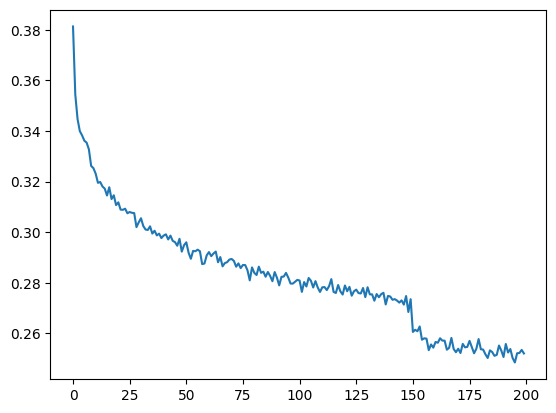

In [97]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [98]:
for layer in model.layers:
    layer.training = False

In [99]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.7666677236557007
val 1.9916812181472778


In [100]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carmah.
ambrie.
khylir.
xithal.
halaysio.
rahnel.
ameryn.
jareti.
nellara.
chaily.
kaleigh.
hamsey.
jaquillis.
lilliana.
brionne.
madiarus.
kaileeni.
sabred.
edi.
abettel.


In [29]:
B,T,C = 4,8,2
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = xbow[b,:t+1] # [t, C]
        xbow[b,t] = torch.mean(xprev,0)
print(xbow)

tensor([[[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])


In [31]:
torch.manual_seed(42)
a = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print(a)
print(b)
print(c)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
tensor([[14., 16.],
        [14., 16.],
        [14., 16.]])
